In [21]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve

## Functions to compute different volatility estimator

In [22]:
def create_dataframe_high_low(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_low'] = hist['Low']
        df[security + '_high'] = hist['High']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_park_volatility(df_high_low, list_securities, window):
    '''
    input
    df = pandas dataframe with columns named: "security_low" and "security_high" (e.g. SSO_low SSO_high)
    list_securities = list of securities name
    window = int, number of days the index has to consider

    output
    df_output = pandas dataframe with securities as columns and parkinson volat estimator as rows

    '''


    k = np.sqrt(1/(4*window*np.log(2)))
    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_high_low) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log(df_high_low[security + '_high'][i+j] / df_high_low[security + '_low'][i+j])**2)
                # len(array_day_value) = window
            square_sum_value = np.sqrt(np.sum(array_day_value))
            array_value = np.append(array_value, k*square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,

def index_df(df_output, data):
    #just add the index to the dataframe
    data_copy = data.copy()
    data_copy.drop(data_copy.head(window).index, inplace=True) # drop last n rows

    return df_output.set_index(data_copy.index)

def dataframe_strd_dev(data, window):
    df_output = pd.DataFrame()

    list_securities = data.columns
    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(data) - window): 
            array_value = np.append(array_value, np.std(data[security][i:i+window]))
            
        # assign new array as column of the df
        df_output[security] = array_value
        
    return df_output

def create_dataframe_ohlc(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_open'] = hist['Open']
        df[security + '_high'] = hist['High']
        df[security + '_low'] = hist['Low']
        df[security + '_close'] = hist['Close']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_satchell_volatility(df_ohlc, list_securities, window):
    '''write descreiption'''

    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_ohlc) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_open'][i+j]))
                                                            + np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_open'][i+j])))
                # len(array_day_value) = window
            square_sum_value = np.sqrt((1/window)*np.sum(array_day_value))
            array_value = np.append(array_value,square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,


## Main

I use the functions create above to study the correlation between the indexes

In [23]:
list_securities = ['SPY', 'TLT', 'GLD']#['SSO', 'UBT', 'UGL'] #['SSO', 'UBT', 'UST', 'UPW', 'UGL']
window = 30 #days

In [24]:
start_date = pd.to_datetime('2007-01-03') 
end_date = date.today()
data = hep.create_dataframe(list_securities)
data = data[start_date: end_date]

data_h_l = create_dataframe_high_low(list_securities)
data_h_l = data_h_l[-len(data):]
#data_h_l = data_h_l[-1834:]
df_park_volat = compute_park_volatility(data_h_l, list_securities, window)
data = hep.create_dataframe(list_securities)
#data = data[-len(data_h_l):]
#data.dropna(inplace = True)
df_park_volat = index_df(df_park_volat, data)

In [25]:
data_return = hep.return_df(data)
df_strd_dev =  dataframe_strd_dev(data_return, 30)
df_strd_dev = index_df(df_strd_dev, data_return)

In [26]:
data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[-len(data):]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)

df_satchell_volat = index_df(df_satchell_volat, data)
df_satchell_volat

,SPY,TLT,GLD
Date,,,
2007-02-15,0.004518,0.003018,0.007899
2007-02-16,0.004356,0.003023,0.007717
2007-02-20,0.004438,0.002929,0.007544
2007-02-21,0.004347,0.002922,0.007873
2007-02-22,0.004348,0.002929,0.007767
...,...,...,...
2022-05-03,0.010080,0.008522,0.006033
2022-05-04,0.010586,0.008626,0.006140
2022-05-05,0.011160,0.008920,0.006169


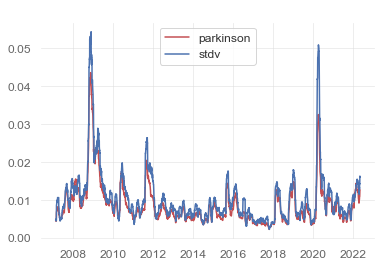

In [27]:
plt.plot(df_park_volat['SPY'], label = 'parkinson', color = 'r')
plt.plot(df_strd_dev['SPY'], label = 'stdv', color = 'b')
plt.title('SPY volatility estimator', color = 'white')
plt.legend()
plt.show()

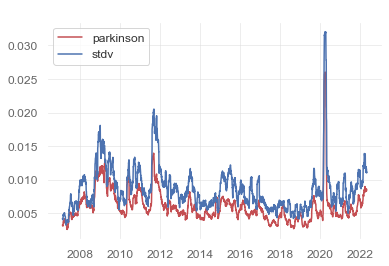

In [28]:
plt.plot(df_park_volat['TLT'], label = 'parkinson', color = 'r')
plt.plot(df_strd_dev['TLT'], label = 'stdv', color = 'b')
plt.title('TLT volatility estimator', color = 'white')
plt.legend()
plt.show()

Text(0.5, 1.0, 'GLD volatility studies')

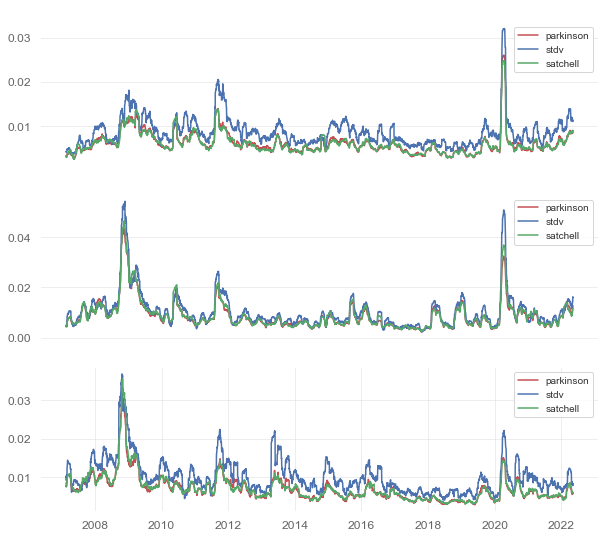

In [29]:
fig, axs = plt.subplots(3)
fig.set_figheight(9)
fig.set_figwidth(10)

axs[0].plot(df_park_volat['TLT'], label = 'parkinson', color = 'r')
axs[0].plot(df_strd_dev['TLT'], label = 'stdv', color = 'b')
axs[0].plot(df_satchell_volat['TLT'], label = 'satchell', color = 'g')
axs[0].axes.get_xaxis().set_visible(False)
axs[0].legend(prop={'size': 10})
axs[0].set_title('TLT volatility studies', color = 'w')

axs[1].plot(df_park_volat['SPY'], label = 'parkinson', color = 'r')
axs[1].plot(df_strd_dev['SPY'], label = 'stdv', color = 'b')
axs[1].plot(df_satchell_volat['SPY'], label = 'satchell', color = 'g')
axs[1].axes.get_xaxis().set_visible(False)
axs[1].legend(prop={'size': 10})
axs[1].set_title('SPY volatility studies', color = 'w')

axs[2].plot(df_park_volat['GLD'], label = 'parkinson', color = 'r')
axs[2].plot(df_strd_dev['GLD'], label = 'stdv', color = 'b')
axs[2].plot(df_satchell_volat['GLD'], label = 'satchell', color = 'g')
axs[2].legend(prop={'size': 10})
axs[2].set_title('GLD volatility studies', color = 'w')


In [30]:
list_securities = ['SPY', 'TLT']
dictionary = {}
data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.

for i in list_securities:
    df_strd_dev = ve.dataframe_strd_dev(data, window)
    df_strd_dev = ve.index_df(df_strd_dev, data, window)
    data_return = hep.return_df(data)
    inv_volat_data = hep.df_inverse_volatility(data_return, window)
    df_weighted = hep.df_wheighted(inv_volat_data)
    data_earnings = hep.df_earnings(df_weighted, data_return)
    data_earnings.dropna(inplace = True)
    
    data_earnings = data_earnings[start_date: end_date]
    
    dictionary['stdv'] = data_earnings[30:]
    
for i in list_securities:
    data_h_l = ve.create_dataframe_high_low(list_securities)   
    #data_h_l = data_h_l[1135: 1135 + 1834]
    data_h_l = data_h_l.loc[start_date: end_date]
    df_volat = ve.compute_park_volatility(data_h_l, list_securities, window)
    data.dropna(inplace = True)
    #data = data[1135: 1135 + 1834]
    data = data[start_date: end_date]
    df_volat = ve.index_df(df_volat, data, window-1)
    df_inv_volat = df_volat.applymap(lambda x: 1/x)
    df_weighted = hep.df_wheighted(df_inv_volat)
    data_r = data.div(data.shift(1))-1
    data_earnings = hep.df_earnings(df_weighted, data_r)
    data_earnings.dropna(inplace = True)
    
    data_earnings = data_earnings[start_date: end_date]
    
    dictionary['park'] = data_earnings

for i in list_securities:
    data_ohlc = ve.create_dataframe_ohlc(list_securities)
    #data_holc = data_holc[1135: 1135 + 1834]
    data_ohlc = data_ohlc[start_date: end_date]
    df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
    data.dropna(inplace = True)
    #data = data[1135: 1135 + 1834]
    data = data[start_date: end_date]
    df_satchell_volat = ve.index_df(df_satchell_volat, data, window-1)
    df_inv_satchell_volat = df_satchell_volat.applymap(lambda x: 1/x)
    df_weighted = hep.df_wheighted(df_inv_satchell_volat)
    
    data_r = data.div(data.shift(1))-1
    data_earnings = hep.df_earnings(df_weighted, data_r)
    data_earnings.dropna(inplace = True)
    
    data_earnings = data_earnings[start_date: end_date]
    
    dictionary['satch'] = data_earnings

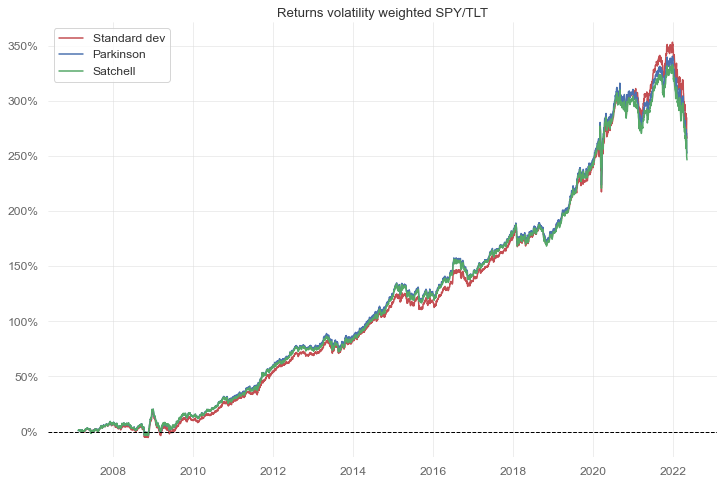

In [31]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)
 
title = 'Returns volatility weighted SPY/TLT'
#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title(title)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(dictionary['stdv']['Tot']), lw=1.5, label='Standard dev', color='r', alpha=1)
ax.plot(compsum(dictionary['park']['Tot']), lw=1.5, label='Parkinson', color='b', alpha=1)
ax.plot(compsum(dictionary['satch']['Tot']), lw=1.5, label='Satchell', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()

In [ ]:
df_volat_SSO = pd.DataFrame()
df_volat_SSO['Stv'] = df_strd_dev['SSO']
df_volat_SSO['Park'] = df_park_volat['SSO']
df_volat_SSO['Satch'] = df_satchell_volat['SSO']

In [ ]:
plt.plot(df_volat_SSO['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_SSO['Stv'], label = 'Std dev')
plt.plot(df_volat_SSO['Satch']*150, label = '150 x Sactchell')
plt.title('Volatility estimator comparison (SSO)', color = 'w')

plt.legend()
plt.savefig('../img/voltility_estimator_comparasion.png')
plt.show()


In [ ]:
df_volat_UBT = pd.DataFrame()
df_volat_UBT['Stv'] = df_strd_dev['UBT']
df_volat_UBT['Park'] = df_park_volat['UBT']
df_volat_UBT['Satch'] = df_satchell_volat['UBT']
plt.plot(df_volat_UBT['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_UBT['Stv'], label = 'Std dev')
plt.plot(df_volat_UBT['Satch']*150, label = '150 x Sactchell')

plt.legend()
plt.show()

In [ ]:
df_volat_UPW = pd.DataFrame()
df_volat_UPW['Stv'] = df_strd_dev['UPW']
df_volat_UPW['Park'] = df_park_volat['UPW']
df_volat_UPW['Satch'] = df_satchell_volat['UPW']
plt.plot(df_volat_UPW['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_UPW['Stv'], label = 'Std dev')
plt.plot(df_volat_UPW['Satch']*150, label = '150 x Sactchell')

plt.legend()
plt.show()

In [ ]:
df_volat_UGL = pd.DataFrame()
df_volat_UGL['Stv'] = df_strd_dev['UGL']
df_volat_UGL['Park'] = df_park_volat['UGL']
df_volat_UGL['Satch'] = df_satchell_volat['UGL']

In [ ]:
corr = df_volat_SSO.corr()
print(corr)

fig = sns.clustermap(corr, figsize=(5,5), cmap='vlag')
#fig.title('Correlation between estimators', color ='w')
fig.savefig('../img/voltility_estimator_correlation.png') 

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Satch'], label = 'SSO')
plt.plot(df_volat_UBT['Satch'], label = 'UBT')
plt.plot(df_volat_UPW['Satch'], label = 'UPW')
plt.plot(df_volat_UGL['Satch'], label = 'UGL')

plt.legend()
plt.title('Sathcell index for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/satch_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Park'], label = 'SSO')
plt.plot(df_volat_UBT['Park'], label = 'UBT')
plt.plot(df_volat_UPW['Park'], label = 'UPW')
plt.plot(df_volat_UGL['Park'], label = 'UGL')

plt.legend()
plt.title('Parkinson index for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/park_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Stv'], label = 'SSO')
plt.plot(df_volat_UBT['Stv'], label = 'UBT')
plt.plot(df_volat_UPW['Stv'], label = 'UPW')
plt.plot(df_volat_UGL['Stv'], label = 'UGL')

plt.legend()
plt.title('Standard deviation for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/stdv_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_strd_dev['UPRO'], label = 'UPRO')
plt.plot(df_strd_dev['TMF'], label = 'TMF')
#plt.plot(df_strd_dev['VGIT'], label = 'VGIT')
plt.plot(df_strd_dev['TYD'], label = 'TYD')
#plt.plot(df_strd_dev['PDBC'], label = 'PDBC')


plt.legend()
plt.title('Standard deviation for the x3 leverage portfolio (only UPRO/TMF/TYD)', color = 'w')
plt.savefig('../img/stdv_x3_UPRO_TMF_TYD_voltility_estimator_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_strd_dev['SSO'], label = 'SSO')
plt.plot(df_strd_dev['UBT'], label = 'UBT')
#plt.plot(df_strd_dev['VGIT'], label = 'VGIT')
plt.plot(df_strd_dev['UGL'], label = 'UGL')
#plt.plot(df_strd_dev['PDBC'], label = 'PDBC')


plt.legend()
plt.title('Standard deviation for the x2 leverage portfolio (only SSO/UBT/UGL)', color = 'w')
plt.savefig('../img/stdv_x2_SSO_UBT_UGL_voltility_estimator_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_strd_dev['VTI'], label = 'VTI')
plt.plot(df_strd_dev['VGLT'], label = 'VGLT')
#plt.plot(df_strd_dev['VGIT'], label = 'VGIT')
plt.plot(df_strd_dev['IAU'], label = 'IAU')
#plt.plot(df_strd_dev['PDBC'], label = 'PDBC')


plt.legend()
plt.title('Standard deviation for the x1 leverage portfolio (only VTI/VGLT/IAU)', color = 'w')
plt.savefig('../img/stdv_x1_VTI_VGLT_IAU_voltility_estimator_comparasion.png')

plt.show()

## Compute the plot above fro the 2007-2012 period

In [ ]:
start_date = pd.to_datetime('2007-01-03') 
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=1814) 
window = 30
list_securities = ['SPY', 'TLT', 'GLD']

In [ ]:
data = hep.create_dataframe(list_securities)
data = data[start_date: end_date]

df_strd_dev =  dataframe_strd_dev(data, window)
df_strd_dev = index_df(df_strd_dev, data)

data_h_l = create_dataframe_high_low(list_securities)
data_h_l = data_h_l[start_date: end_date]
df_park_volat = compute_park_volatility(data_h_l, list_securities, window)
df_park_volat = index_df(df_park_volat, data)

data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[start_date: end_date]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)
df_satchell_volat = index_df(df_satchell_volat, data)

In [ ]:
df_volat_SPY = pd.DataFrame()
df_volat_SPY['Stv'] = df_strd_dev['SPY']
df_volat_SPY['Park'] = df_park_volat['SPY']
df_volat_SPY['Satch'] = df_satchell_volat['SPY']

df_volat_TLT = pd.DataFrame()
df_volat_TLT['Stv'] = df_strd_dev['TLT']
df_volat_TLT['Park'] = df_park_volat['TLT']
df_volat_TLT['Satch'] = df_satchell_volat['TLT']

df_volat_GLD = pd.DataFrame()
df_volat_GLD['Stv'] = df_strd_dev['GLD']
df_volat_GLD['Park'] = df_park_volat['GLD']
df_volat_GLD['Satch'] = df_satchell_volat['GLD']

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Satch'], label = 'SPY')
plt.plot(df_volat_TLT['Satch'], label = 'TLT')
plt.plot(df_volat_GLD['Satch'], label = 'GLD')

plt.legend()
plt.title('Sathcell index for the all weather', color = 'w')
plt.savefig('../img/satch_potrfolio_2008_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Park'], label = 'SPY')
plt.plot(df_volat_TLT['Park'], label = 'TLT')
plt.plot(df_volat_GLD['Park'], label = 'GLD')

plt.legend()
plt.title('Parkinson index for the all weather', color = 'w')
plt.savefig('../img/park_2008_potrfolio_comparasion.png')

plt.show()

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Stv'], label = 'SPY')
plt.plot(df_volat_TLT['Stv'], label = 'TLT')
plt.plot(df_volat_GLD['Stv'], label = 'GLD')

plt.legend()
plt.title('Standard deviation index for the all weather', color = 'w')
plt.savefig('../img/stdv_2008_potrfolio_comparasion.png')

plt.show()

## Other investigation

In [ ]:
start_date = pd.to_datetime('2020-09-09') 
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=300) 
window = 30
list_securities = ['VGLT', 'VTI', 'IAU']

In [ ]:
data = hep.create_dataframe(list_securities)
data = data[start_date: end_date]

data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[start_date: end_date]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)
df_satchell_volat = index_df(df_satchell_volat, data)

In [ ]:
df_satchell_volat

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_satchell_volat['VTI'], label = 'VTI')
plt.plot(df_satchell_volat['VGLT'], label = 'VGLT')
#plt.plot(df_strd_dev['VGIT'], label = 'VGIT')
plt.plot(df_satchell_volat['IAU'], label = 'IAU')
#plt.plot(df_strd_dev['PDBC'], label = 'PDBC')


plt.legend()
plt.title('Satchell for the x1 leverage portfolio (only VTI/VGLT/IAU)', color = 'w')
plt.show()